ERSIP Lab Sessions    
Lab 4: Image features  
09-10-2025

**Load an image containing crossing edges e.g., a US-like urban RS image**

*Data Source: [urban tree detection](https://github.com/jonathanventura/urban-tree-detection?tab=readme-ov-file).   
This dataset is an [NAIP](https://registry.opendata.aws/naip/) 2020 tile from Los Angeles.*

In [1]:
import cv2
import numpy as np
import rasterio
import matplotlib.pyplot as plt

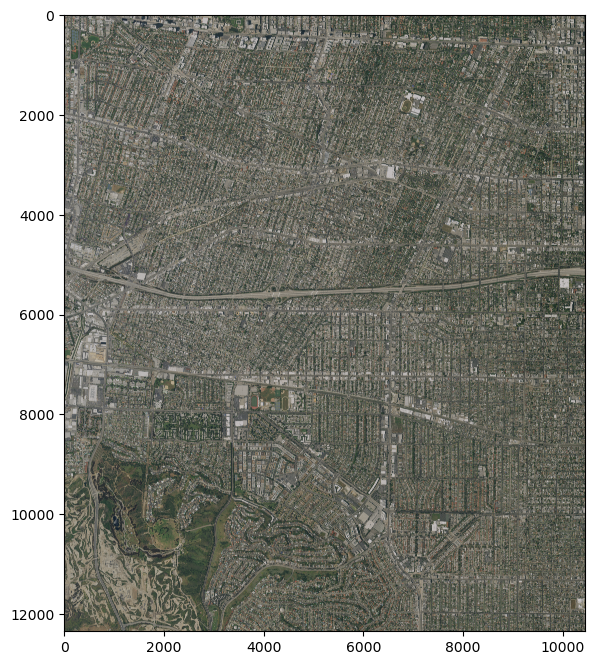

In [2]:
# load image
src = rasterio.open(r'Data/m_3411862_sw_11_060_20200505.tif')
img = src.read([1,2,3])  # read RGB bands 
rgb = np.transpose(img, (1, 2, 0))

# display image
plt.figure(figsize=(8,8))
plt.imshow(rgb)
plt.show()

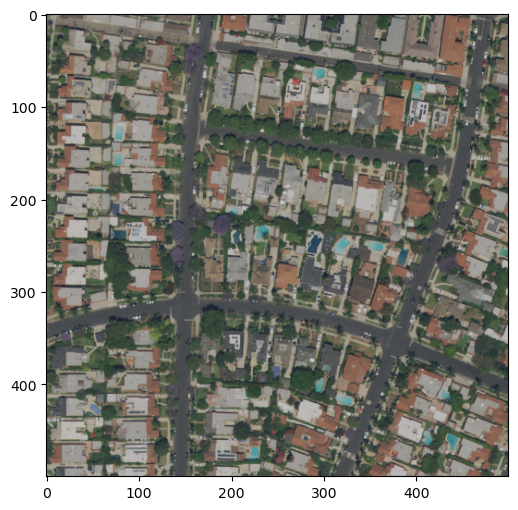

In [3]:
# crop image
rgb_crop = rgb[1000:1500, 500:1000, :]

# display image
plt.figure(figsize=(6,6))
plt.imshow(rgb_crop)
plt.show()

**Extract the corners with Harris detector e.g, road junctions**

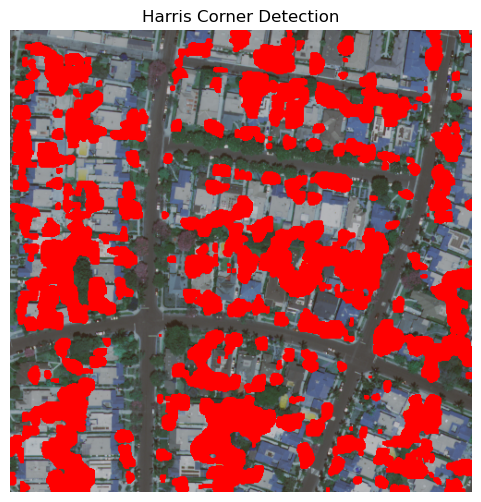

In [4]:
import cv2

# grayscale image
img_gray = src.read(1)  # read first band
img_crop = img_gray[1000:1500, 500:1000]

'''Harris edge detector:
    1) 17 = block size (size of neighborhood for corner detection. Large values less small detail; smaller values more noise).
    2) 21 = k size; aperture parameter for the Sobel operator (gradient calculation). Larger= gradient computation is smoother; reduces noise, corners are broader.
        Smaller = sharper gradients; may detect more corners, including noise.
    3) 0.01 = Harris detector free parameter k (sensitivity to corners).Lower more points considered corners, may include edges; Higher fewer points, only strong corners are kept.
    4) Output is an array of the same size as the image, where higher values indicate stronger corners.
'''
edges = cv2.cornerHarris(img_crop, 17, 21, 0.01)  
edges = cv2.dilate(edges, None)

# mark corners on the original image
rgb_crop[edges > 0.1 * edges.max()] = [0, 0, 255]
img_rgb = cv2.cvtColor(rgb_crop, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.title('Harris Corner Detection')
plt.axis('off')  
plt.show()

**Compute the main orientations with Hough transform**

In [5]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt

# Adaptive Canny edge detection 
median_val = np.median(img_gray)
lower = int(max(0, 0.66 * median_val))
upper = int(min(255, 1.33 * median_val))
edges = cv2.Canny(img_gray, lower, upper)

# Full Hough Transform (all lines)
lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=0)  # threshold=0 to get all votes

# Extract anglesb
thetas = np.array([theta for rho, theta in lines[:,0,:]])
angles = np.degrees(thetas)          # radians → degrees
angles = (angles + 180) % 180 - 90   # wrap to [-90, 90]

# Histogram to find main orientations
hist, bin_edges = np.histogram(angles, bins=36, range=(-90, 90))  # 5° bins
top_indices = np.argsort(hist)[-3:]  # top 3 dominant angles
main_orientations = bin_edges[top_indices]

print("Main line orientations (degrees):", main_orientations)

Main line orientations (degrees): [ 45. -40. -45.]


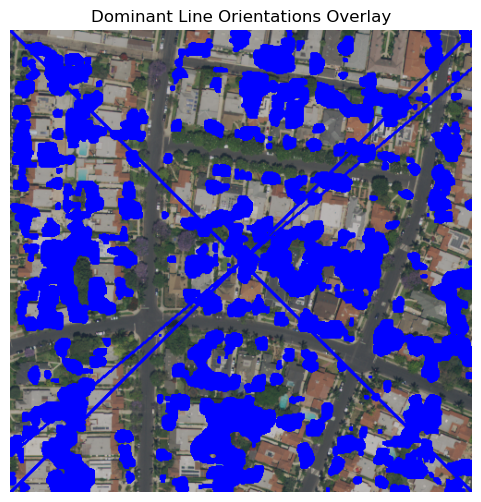

In [6]:
width, height = img_rgb.shape[1], img_rgb.shape[0]

# Create a copy to draw on
img_overlay = img_rgb.copy()

for angle in main_orientations:
    theta_rad = np.radians(angle)
    # Draw line through image center
    x0, y0 = width // 2, height // 2
    length = max(width, height)
    x1 = int(x0 + length * np.cos(theta_rad))
    y1 = int(y0 + length * np.sin(theta_rad))
    x2 = int(x0 - length * np.cos(theta_rad))
    y2 = int(y0 - length * np.sin(theta_rad))
    cv2.line(img_overlay, (x1, y1), (x2, y2), (255,0,0), 2)  # blue lines

# Plot the image with overlay
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB))
plt.title("Dominant Line Orientations Overlay")
plt.axis("off")
plt.show()

**Download the UC Merced Land Use dataset. Select randomly 10 images per class**

In [7]:
import os
import random
import shutil

# Path to the dataset
dataset_path = r"Data/UCMerced_LandUse/Images" 
output_path = r"Data/UCMerced_LandUse_random"

# Make output folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# List all class folders
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]
print("Detected classes:", classes)

# Allowed image extensions
valid_extensions = ('.tif', '.tiff', '.jpg', '.jpeg', '.png')

# Loop through classes and randomly select 10 images
for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    # List all valid images in the class folder
    images = [f for f in os.listdir(class_folder) if f.lower().endswith(valid_extensions)]
    # print(f"Class '{cls}' has {len(images)} images")
    if not images:
        print(f"No images found in class '{cls}', skipping.")
        continue
    # Randomly select 10 images (or all if less than 10)
    selected_images = random.sample(images, min(10, len(images)))
    # Create folder for this class in output
    output_class_folder = os.path.join(output_path, cls)
    os.makedirs(output_class_folder, exist_ok=True)
    # Copy selected images
    for img_file in selected_images:
        src_file = os.path.join(class_folder, img_file)
        dst_file = os.path.join(output_class_folder, img_file)
        shutil.copy2(src_file, dst_file)

print("\nRandom selection of 10 images per class completed.")


Detected classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

Random selection of 10 images per class completed.


**Compute the Haralick features for these images**

In [8]:
import mahotas

# Path to the random selection folder
classes_path = r"Data/UCMerced_LandUse_random"  # each class is a subfolder

# List all class folders
classes = [cls for cls in os.listdir(classes_path) if os.path.isdir(os.path.join(classes_path, cls))]
print("Detected classes:", classes)

# Dictionary to store features per class
features_dict = {}

# Loop through classes and compute Haralick features
for cls in classes:
    class_folder = os.path.join(classes_path, cls)
    images_in_class = [f for f in os.listdir(class_folder) if f.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png'))]
    if not images_in_class:
        print(f"Class '{cls}' has no images, skipping.")
        continue
    features_dict[cls] = []
    for img_file in images_in_class:
        img_path = os.path.join(class_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
        
        # Compute Haralick features (13 features per image)
        haralick_features = mahotas.features.haralick(img).mean(axis=0)
        features_dict[cls].append(haralick_features)
        # print(f"Computed features for {cls}/{img_file}, shape: {haralick_features.shape}")

# Summary
print("\n--- Summary ---")
for cls in features_dict:
    num_images = len(features_dict[cls])
    if num_images > 0:
        num_features = len(features_dict[cls][0])
        print(f"Class '{cls}': {num_images} images, {num_features} features each")
    else:
        print(f"Class '{cls}': 0 images, 0 features")


Detected classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']

--- Summary ---
Class 'agricultural': 10 images, 13 features each
Class 'airplane': 10 images, 13 features each
Class 'baseballdiamond': 10 images, 13 features each
Class 'beach': 10 images, 13 features each
Class 'buildings': 10 images, 13 features each
Class 'chaparral': 10 images, 13 features each
Class 'denseresidential': 10 images, 13 features each
Class 'forest': 10 images, 13 features each
Class 'freeway': 10 images, 13 features each
Class 'golfcourse': 10 images, 13 features each
Class 'harbor': 10 images, 13 features each
Class 'intersection': 10 images, 13 features each
Class 'mediumresidential': 10 images, 13 features each
Class 'mobilehomepark': 10 images, 13 f

**Apply a basic retrieval scheme through computing features on an input image and looking for its nearest neighbors among the reference images**

In [10]:
classes_path = r"Data/UCMerced_LandUse_random"  # reference images
query_image_path = r"Data/UCMerced_LandUse_random/agricultural/agricultural07.tif"  # query image

# Flatten features_dict for retrieval
ref_features = []
ref_labels = []
ref_image_paths = []

for cls in features_dict:
    class_folder = os.path.join(classes_path, cls)
    images_in_class = [f for f in os.listdir(class_folder) if f.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png'))]

    for img_file, f in zip(images_in_class, features_dict[cls]):
        full_path = os.path.join(class_folder, img_file)
        # Skip the query image itself
        if os.path.abspath(full_path) == os.path.abspath(query_image_path):
            continue

        ref_features.append(f)            # Haralick features
        ref_labels.append(cls)            # class label
        ref_image_paths.append(full_path) # actual image path

ref_features = np.array(ref_features)
print(f"Prepared {len(ref_features)} reference images for retrieval (query excluded).")

# Compute features for the query image
query_img = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)
if query_img is None:
    raise ValueError(f"Query image not found: {query_image_path}")

query_feature = mahotas.features.haralick(query_img).mean(axis=0)

# Compute distances and find nearest neighbors
distances = np.linalg.norm(ref_features - query_feature, axis=1)
sorted_idx = np.argsort(distances)
top_k = 5

print(f"\nTop {top_k} nearest neighbors:")
for rank, idx in enumerate(sorted_idx[:top_k]):
    print(f"{rank+1}: {ref_labels[idx]} (distance={distances[idx]:.3f}) - {ref_image_paths[idx]}")



Prepared 209 reference images for retrieval (query excluded).

Top 5 nearest neighbors:
1: agricultural (distance=590.829) - Data/UCMerced_LandUse_random\agricultural\agricultural69.tif
2: sparseresidential (distance=1092.212) - Data/UCMerced_LandUse_random\sparseresidential\sparseresidential20.tif
3: runway (distance=1097.649) - Data/UCMerced_LandUse_random\runway\runway66.tif
4: baseballdiamond (distance=1110.512) - Data/UCMerced_LandUse_random\baseballdiamond\baseballdiamond62.tif
5: chaparral (distance=1144.713) - Data/UCMerced_LandUse_random\chaparral\chaparral83.tif


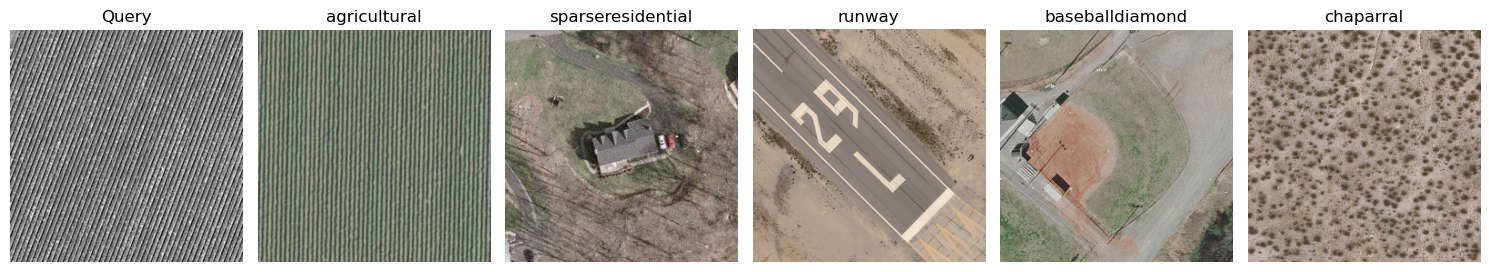

In [11]:
# Visualize query and retrieved images
plt.figure(figsize=(15,5))

# Show query image
plt.subplot(1, top_k+1, 1)
plt.imshow(query_img, cmap='gray')
plt.title("Query")
plt.axis('off')

# Show retrieved images
for i, idx in enumerate(sorted_idx[:top_k]):
    retrieved_img = cv2.imread(ref_image_paths[idx])
    if retrieved_img is None:
        print(f"Failed to read image: {ref_image_paths[idx]}")
        continue
    retrieved_img = cv2.cvtColor(retrieved_img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, top_k+1, i+2)
    plt.imshow(retrieved_img)
    plt.title(ref_labels[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()
